In [ ]:
## This is a series of examples demonstrating the use of the icanswim/qchem repo 
## for quantum mechanic geometric machine learning utilizing pytorch, pyg and rdkit.
## This is a demonstration of the use of the icanswim/cosmosis repo for 
## data science and machine learning projects.

In [1]:
import sys # required for relative imports in jupyter lab
sys.path.insert(0, '../')

import warnings
warnings.filterwarnings('ignore', category=UserWarning,
                            message='TypedStorage is deprecated')

import copy
import numpy as np

from cosmosis.model import FFNet
from cosmosis.dataset import SKDS, Pad, Flatten, Reshape, SqueezeN, Index
from cosmosis.learning import Learn, Selector

from dataset import QM7, QM7b, QM7X, ANI1x, QM9, PGDS
from model import pyg_model, GraphNet, GlobalAttentionNet

from torch.optim import Adam
from torch.nn import MSELoss, L1Loss, NLLLoss, CrossEntropyLoss
from torch.optim.lr_scheduler import ReduceLROnPlateau

from torch_geometric.loader import DataLoader
import torch_geometric.transforms as T

In [2]:
#example exploring cosmosis/qchem QM9 dataset 
#use the qchem rdkit branch for rdkit data augmentation

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['atomic_number','mulliken'],
                                                             'coulomb': ['coulomb'],
                                                            },
                                             'criterion_input': {'target': ['U0']}},
                              'n': 1000, #non-random subset for testing,
                              'use_pickle': False}}

qm9 = QM9(**ds_params['train_params'])
qm9[1]

creating QM9 dataset...
molecules scanned:  1
molecules created:  1
total molecules scanned:  1000
total uncharacterized molecules removed:  25
total molecules created:  975
CDataset created...


{'model_input': {'X': array([ 6.      ,  1.      ,  1.      ,  1.      ,  1.      , -0.535689,
          0.133921,  0.133922,  0.133923,  0.133923], dtype=float32),
  'coulomb': array([[36.858112 , 10.765641 , 10.765888 , 10.765677 , 10.765863 ],
         [ 0.9157932,  0.5      ,  1.7943147,  1.7942796,  1.7943105],
         [ 0.9157932,  1.7942736,  0.5      ,  1.7942796,  1.7943105],
         [ 0.9157932,  1.7942736,  1.7943147,  0.5      ,  1.7943105],
         [ 0.9157932,  1.7942736,  1.7943147,  1.7942796,  0.5      ]],
        dtype=float32)},
 'criterion_input': {'target': array([-40.47893], dtype=float32)}}

In [3]:
#example exploring cosmosis/qchem QM9 dataset
l, s, li, si = 0, 9999, 0, 0
for i in qm9.ds_idx:
    d = qm9[i]['model_input']['X'].shape[0]
    if d > l:
        l = d
        li = i
    if d < s:
        s = d
        si = i
print('longest molecule index: ', li, ' length: ', l)
print('shortest molecule index: ', si, ' length: ', s)
qm9[si]

longest molecule index:  228  length:  40
shortest molecule index:  3  length:  6


{'model_input': {'X': array([ 8.      ,  1.      ,  1.      , -0.589706,  0.294853,  0.294853],
        dtype=float32),
  'coulomb': array([[73.51671  , 35.90347  , 35.90347  ],
         [ 1.0393857,  0.5      ,  4.4879336],
         [ 1.0393857,  4.4879336,  0.5      ]], dtype=float32)},
 'criterion_input': {'target': array([-76.4047], dtype=float32)}}

In [4]:
#example exploring cosmosis/qchem PyG dataset wrapper with Data object output
import copy
class IndexY(T.BaseTransform):
    def __init__(self, i):
        self.i = i
        
    def __call__(self, data):
        # Shallow-copy the data so that we prevent in-place data modification.
        return self.forward(copy.copy(data))
    
    def forward(self, data):
        y = data.y[:,self.i]
        data.y = y
        return data

ds_params = {'train_params': {'dataset': 'QM9',
                              'pg_params': {'root': './data/',
                                            'transform': IndexY(1)}}}

pgds = PGDS(**ds_params['train_params'])
ds_idx = np.arange(1000)
selector = Selector(train_idx=ds_idx)
selector('train')
loader = DataLoader(pgds, batch_size=2, sampler=selector)
batch = next(iter(loader))
print('batch: ', batch)
print('batch.ptr: ', batch.ptr)
print('batch.idx: ', batch.idx)
print('batch.x: ', batch.x)
print('pgds[1]: ', pgds[1])
print('pgds[1].x: ', pgds[1].x)
print('pgds[1].y: ', pgds[1].y)
print('pgds[1].idx: ', pgds[1].idx)

creating pytorch geometric QM9 dataset...
CDataset created...
batch:  DataBatch(x=[22, 11], edge_index=[2, 46], edge_attr=[46, 4], y=[2], pos=[22, 3], z=[22], name=[2], idx=[2], batch=[22], ptr=[3])
batch.ptr:  tensor([ 0, 11, 22])
batch.idx:  tensor([511, 105])
batch.x:  tensor([[0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 3.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 2.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 7., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 2.],
        [0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 

creating QM9 dataset...
molecules scanned:  1
molecules created:  0
molecules scanned:  10001
molecules created:  9551
total molecules scanned:  10450
total uncharacterized molecules removed:  265
total molecules created:  9735
CDataset created...
FFNet model loaded...
CModel loaded...
running model on gpu...
learning time: 0:00:03.303268
epoch: 0, lr: 0.01
train loss: 118.40256806139676, val loss: 24.452348188920453
learning time: 0:00:14.857179
epoch: 7, lr: 0.01
train loss: 10.302421542833436, val loss: 11.000505794178356
learning time: 0:00:19.875362
epoch: 10, lr: 0.01
train loss: 10.577512498171824, val loss: 8.732572772286154
learning time: 0:00:29.991450
epoch: 16, lr: 0.005
train loss: 7.190036422801468, val loss: 6.869263562289151
test loss: 6.076862335205078
learning time: 0:00:35.248094


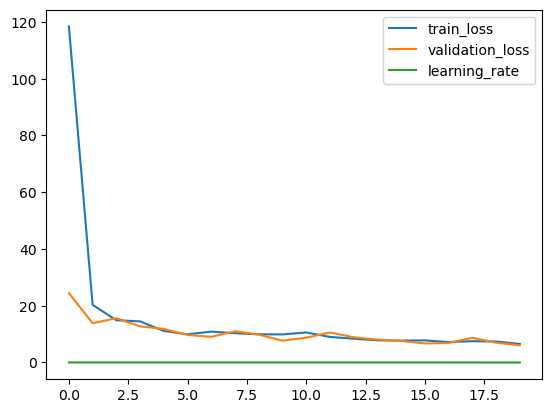

In [5]:
#example cosmosis/qchem QM9 dataset with filter
#use the qchem rdkit branch for rdkit data augmentation

qm9_features = ['A','B','C','mu','alpha','homo','lumo', 'gap','r2','zpve',
                'U0','U','H','G','Cv','qm9_n_atoms','qm9_block','qm9_atom_type',
                'qm9_xyz','mulliken','in_file','smile','distance','coulomb']

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['coulomb']},
                                             'criterion_input': {'target': ['U0']}},
                              'n': 10000, #non-random subset for testing
                              'transforms': {'coulomb': [Pad((29,29)),Reshape((-1))],
                                             'U0': [SqueezeN()]},
                              'filter_on': ('n_atoms','>','10'), #filter out molecules with less than 10 atoms
                              'use_pickle': False}}

model_params = {'in_channels': 29*29, 
                'hidden': 4096, 
                'out_channels': 1, 
                'model_name': 'funnel'
               }
                
metrics_params = {'report_interval': 1,
                  'log_plot': False}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 1}

opt_params = {'lr': 0.01}

l = Learn([QM9], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss,
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          squeeze_y_pred=True, batch_size=128, epochs=20)

creating pytorch geometric QM9 dataset...
CDataset created...
CModel loaded...
running model on gpu...
learning time: 0:00:07.855171
epoch: 0, lr: 0.01
train loss: 3.5697806315595697, val loss: 3.203317381833729
learning time: 0:00:23.876827
epoch: 2, lr: 0.01
train loss: 3.12350326425889, val loss: 3.120345717982242
learning time: 0:00:39.629047
epoch: 4, lr: 0.01
train loss: 3.0665216839947953, val loss: 3.0086642660592733
learning time: 0:00:55.223161
epoch: 6, lr: 0.005
train loss: 2.9958194891611734, val loss: 2.961506636519181
learning time: 0:01:10.807778
epoch: 8, lr: 0.005
train loss: 2.940224304920485, val loss: 2.911814526507729
learning time: 0:01:26.413486
epoch: 10, lr: 0.005
train loss: 2.9036274410429455, val loss: 2.9093399518414547
learning time: 0:01:41.982993
epoch: 12, lr: 0.005
train loss: 2.889327226900587, val loss: 2.868444596466265
learning time: 0:01:58.129591
epoch: 14, lr: 0.005
train loss: 2.826556311602018, val loss: 2.810457866442831
learning time: 0:02:

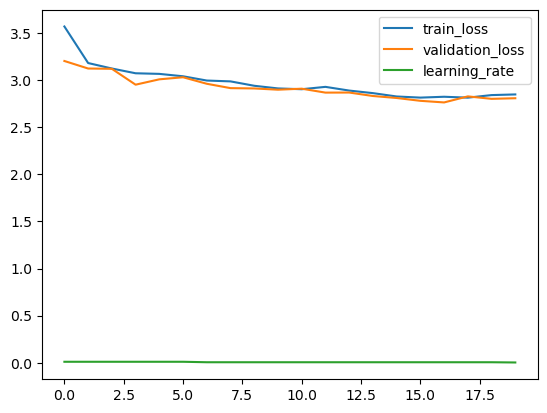

In [7]:
#example cosmosis/qchem PyG dataset wrapper with Data object output with
#custum transforms and sklearn metrics and custom PyG model
class IndexY(T.BaseTransform):
    def __init__(self, i):
        self.i = i
        
    def __call__(self, data):
        # Shallow-copy the data so that we prevent in-place data modification.
        return self.forward(copy.copy(data))
    
    def forward(self, data):
        y = data.y[:,self.i]
        data.y = y
        return data

model_params = {'in_channels': 11, 
                'hidden': 512, 
                'out_channels': 1,
                'depth': 2}


ds_params = {'train_params': {'dataset': 'QM9',
                              'transforms': {},
                              'pg_params': {'root': './data/',
                                            'transform': T.Compose([IndexY(0), 
                                                                    T.AddSelfLoops()])}}}

metrics_params = {'report_interval': 10,
                  'log_plot': False}

opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7, .15)}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 1}

l = Learn([PGDS], GraphNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=MSELoss, DataLoader=DataLoader,
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          squeeze_y_pred=True, batch_size=256, epochs=20)

creating pytorch geometric QM9 dataset...
CDataset created...
FFNet model loaded...
CModel loaded...
running model on gpu...
learning time: 0:00:06.623158
epoch: 0, lr: 0.01
train loss: 1.4480644182330753, val loss: 1.2482180493442636
learning time: 0:00:19.681242
epoch: 2, lr: 0.01
train loss: 1.13257343829179, val loss: 1.2297060246530331
learning time: 0:00:32.217510
epoch: 4, lr: 0.01
train loss: 1.0304317926826263, val loss: 1.0471194904101522
learning time: 0:00:44.696354
epoch: 6, lr: 0.01
train loss: 0.9746489219304895, val loss: 1.0009395386043347
learning time: 0:00:57.184859
epoch: 8, lr: 0.01
train loss: 0.911673046126753, val loss: 0.9816605158542332
learning time: 0:01:10.070238
epoch: 10, lr: 0.01
train loss: 0.8783266692936254, val loss: 0.9797228017919942
learning time: 0:01:22.745768
epoch: 12, lr: 0.01
train loss: 0.843904301732862, val loss: 0.9295607938578254
learning time: 0:01:35.144236
epoch: 14, lr: 0.01
train loss: 0.809592146666444, val loss: 0.93058589336119

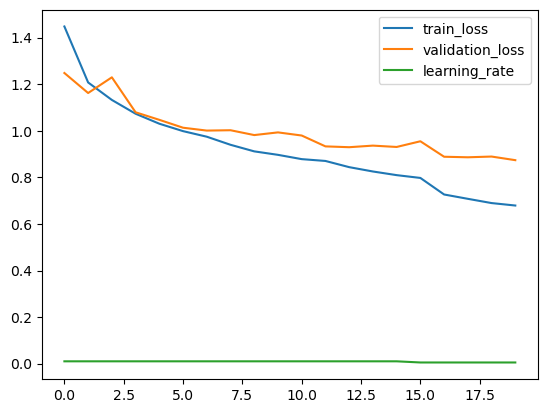

In [9]:
#example cosmosis/qchem PyG dataset wrapper with custum transform with
#dictionary output and custom cosmosis model

model_params = {'in_channels': 319, 
                'hidden': 512, 
                'out_channels': 1, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'dataset': 'QM9',
                              'transforms': {'y': [Index(0)],
                                             'x': [Pad((29,11)), Flatten()]},
                              'input_dict': {'model_input': {'X': ['x']},
                                             'criterion_input': {'target': ['y']}},
                              'pg_params': {'root': './data/'}}}

metrics_params = {'report_interval': 10,
                  'log_plot': False}

opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7, .15)}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 1}

l = Learn([PGDS], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=MSELoss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          batch_size=256, epochs=20)

creating pytorch geometric QM9 dataset...
CDataset created...
CModel loaded...
running model on gpu...
learning time: 0:00:07.721714
epoch: 0, lr: 0.01
train loss: 9.415187264023041, val loss: 9.30545441100472
learning time: 0:00:23.338856
epoch: 2, lr: 0.01
train loss: 9.412251258764615, val loss: 9.298134013226157
learning time: 0:00:38.951382
epoch: 4, lr: 0.005
train loss: 9.411563472587522, val loss: 9.307770233405265
learning time: 0:00:54.394828
epoch: 6, lr: 0.005
train loss: 9.416168609587084, val loss: 9.310763478279114
learning time: 0:01:09.666644
epoch: 8, lr: 0.005
train loss: 9.416083974330698, val loss: 9.298412937867013
test loss: 9.45997220591495
learning time: 0:01:18.925427


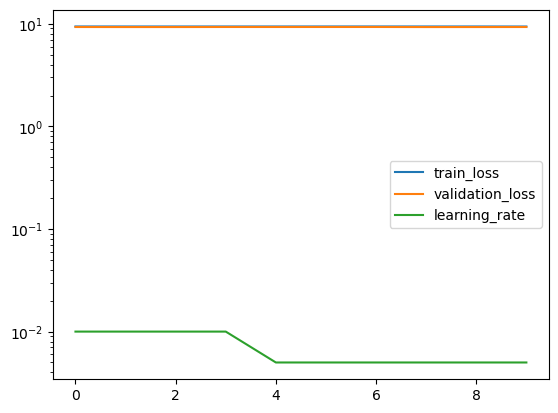

In [10]:
#example cosmosis/qchem PyG dataset wrapper with Data object output with
#custum transforms and custom PyG model

class IndexY(T.BaseTransform):
    def __init__(self, i):
        self.i = i
        
    def __call__(self, data):
        # Shallow-copy the data so that we prevent in-place data modification.
        return self.forward(copy.copy(data))
    
    def forward(self, data):
        y = data.y[:,self.i]
        data.y = y
        return data

model_params = {'in_channels': 11, 
                'hidden': 512, 
                'out_channels': 1,
                'depth': 2}

ds_params = {'train_params': {'dataset': 'QM9',
                              'transforms': {},
                              'pg_params': {'root': './data/',
                                            'transform': T.Compose([IndexY(0), 
                                                                    T.AddSelfLoops()])}}}

metrics_params = {'report_interval': 10,
                  'log_plot': True}

opt_params = {'lr': 0.01}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7, .15)}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 1}

l = Learn([PGDS], GlobalAttentionNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=MSELoss, DataLoader=DataLoader,
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          squeeze_y_pred=True, batch_size=256, epochs=10)

CDataset created...
FFNet model loaded...
CModel loaded...
running model on gpu...
learning time: 0:00:00.769919
epoch: 0, lr: 0.01
train loss: 1487.7923583984375, val loss: 1402.90625
learning time: 0:00:07.448362
epoch: 10, lr: 0.005
train loss: 45.47507677580181, val loss: 42.17740821838379
test loss: 38.71323490142822
learning time: 0:00:13.771876


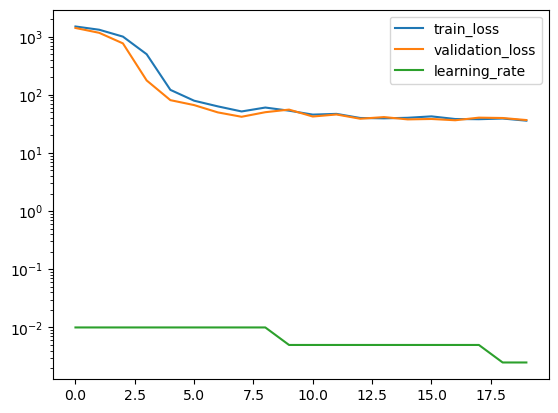

In [11]:
#example using cosmosis/qchem QM7 dataset and custom cosmosis model
model_params = {'in_channels': 23*23, 
                'hidden': 2048, 
                'out_channels': 1, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['coulomb']},
                                             'criterion_input': {'target': ['ae']}},
                              'in_file': './data/qm7/qm7.mat',
                              'transforms': {'coulomb': [Flatten()]}}}

metrics_params = {'report_interval': 10,
                  'log_plot': True}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 1,
                'cooldown': 2}

opt_params = {'lr': 0.01}

l = Learn([QM7], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          batch_size=256, epochs=20)

CDataset created...
FFNet model loaded...
CModel loaded...
running model on gpu...
learning time: 0:00:00.714075
epoch: 0, lr: 0.01
train loss: 1513.9791516755756, val loss: 1430.8057250976562
learning time: 0:00:06.932630
epoch: 10, lr: 0.01
train loss: 59.021073592336556, val loss: 74.03103446960449
test loss: 52.12148571014404
learning time: 0:00:12.778863


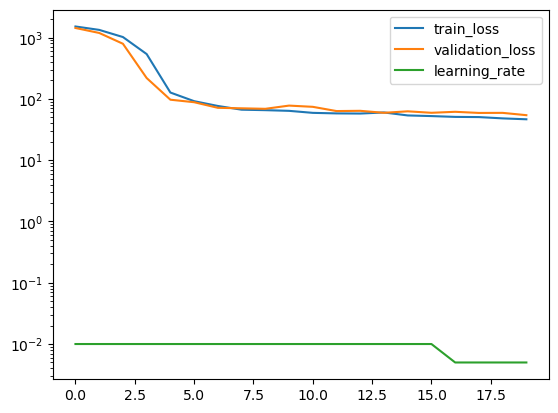

In [13]:
#example using the cosmosis/qchem QM7b dataset and custom cosmosis model
model_params = {'in_channels': 23*23, 
                'hidden': 2048, 
                'out_channels': 1, 
                'model_name': 'funnel'}

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['coulomb']},
                                             'criterion_input': {'target': ['E']}},
                              'in_file': './data/qm7b/qm7b.mat',
                              'transforms': {'coulomb': [Flatten()]}}}

metrics_params = {'report_interval': 10,
                  'log_plot': True}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 1}

opt_params = {'lr': 0.01}

l = Learn([QM7b], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params, 
          batch_size=256, epochs=20)

In [14]:
#example exploring cosmosis/qchem QM7X dataset

features = ['DIP','HLgap','atC6','atNUM','atPOL','atXYZ','eAT','hDIP',
            'eC','eDFTB+MBD','eEE','eH','eKIN','eKSE','eL','eMBD','eNE', 
            'eNN','ePBE0','ePBE0+MBD','eTS','eX','eXC','eXX','hCHG', 
            'hRAT','hVDIP','hVOL','mC6','mPOL','mTPOL','pbe0FOR', 
            'sMIT','sRMSD','totFOR','vDIP','vEQ','vIQ','vTQ','vdwFOR','vdwR',
            'coulomb'] #(1110,) with pad=23

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['atNUM']},
                                             'criterion_input': {'target': ['eAT']}},
                              'transforms': {},
                              'n': 1000, #non-random subset for testing
                              'selector': ['opt']}}

qm7x = QM7X(**ds_params['train_params'])

l, m = 0, 0
for i in qm7x.ds_idx:
    s = qm7x[i]['model_input']['X'].shape[0]
    if s > l:
        l = s
        m = i
print('longest molecule length: ', l, ' index: ', m)
print(qm7x[m]['model_input']['X'].shape) 
qm7x[m]


mapping...  <HDF5 file "1000.hdf5" (mode r)>
mapping...  <HDF5 file "2000.hdf5" (mode r)>
mapping...  <HDF5 file "3000.hdf5" (mode r)>
mapping...  <HDF5 file "4000.hdf5" (mode r)>
mapping...  <HDF5 file "5000.hdf5" (mode r)>
mapping...  <HDF5 file "6000.hdf5" (mode r)>
mapping...  <HDF5 file "7000.hdf5" (mode r)>
mapping...  <HDF5 file "8000.hdf5" (mode r)>
molecular formula (idmol) mapped:  1000
total molecular structures (idconf) mapped:  3723
CDataset created...
longest molecule length:  20  index:  233
(20,)


{'model_input': {'X': array([6., 6., 6., 6., 6., 6., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1.], dtype=float32)},
 'criterion_input': {'target': array([89.31956], dtype=float32)}}

mapping...  <HDF5 file "1000.hdf5" (mode r)>
mapping...  <HDF5 file "2000.hdf5" (mode r)>
mapping...  <HDF5 file "3000.hdf5" (mode r)>
mapping...  <HDF5 file "4000.hdf5" (mode r)>
mapping...  <HDF5 file "5000.hdf5" (mode r)>
mapping...  <HDF5 file "6000.hdf5" (mode r)>
mapping...  <HDF5 file "7000.hdf5" (mode r)>
mapping...  <HDF5 file "8000.hdf5" (mode r)>
molecular formula (idmol) mapped:  1000
total molecular structures (idconf) mapped:  3723
CDataset created...
FFNet model loaded...
CModel loaded...
running model on gpu...
learning time: 0:00:00.645692
epoch: 0, lr: 0.01
train loss: 44.50050392150879, val loss: 13.735087871551514
test loss: 5.461254596710205
learning time: 0:00:06.159359


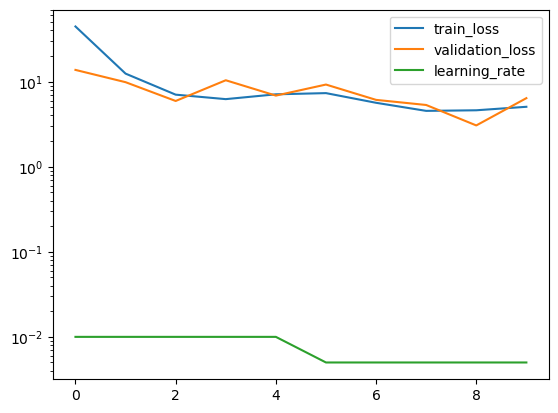

In [15]:
#example using the cosmosis/qchem QM7X dataset with filter and custom cosmosis model
model_params = {'in_channels': 23*23,
                'hidden': 2048, 
                'out_channels': 1, 
                'model_name': 'funnel'}

features = ['DIP','HLgap','atC6','atNUM','atPOL','atXYZ','hDIP','eAT',
            'eC','eDFTB+MBD','eEE','eH','eKIN','eKSE','eL','eMBD','eNE', 
            'eNN','ePBE0','ePBE0+MBD','eTS','eX','eXC','eXX','hCHG', 
            'hRAT','hVDIP','hVOL','mC6','mPOL','mTPOL','pbe0FOR', 
            'sMIT','sRMSD','totFOR','vDIP','vEQ','vIQ','vTQ','vdwFOR','vdwR',
            'coulomb','distance']

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['coulomb']},
                                             'criterion_input': {'target': ['eAT']}},
                              'transforms': {'coulomb': [Pad((23,23)), Flatten()]},
                              'selector': ['opt'],
                              'n': 1000, #non-random subset for testing
                             }}

metrics_params = {'report_interval': 10,
                  'log_plot': True}

crit_params = {'reduction': 'sum'}

sample_params = {'set_seed': 88,
                 'splits': (.7,.15),
                 #'subset': .2 #create random subset
                } 

sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 1}

opt_params = {'lr': 0.01}

l = Learn([QM7X], FFNet, Selector, 
          Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          metrics_params=metrics_params,
          batch_size=64, epochs=10)

molecules loaded:  1000
molecules loaded:  2000
molecules loaded:  3000
molecules loaded:  3114
CDataset created...
FFNet model loaded...
CModel loaded...
running model on gpu...
learning time: 0:00:01.343700
epoch: 0, lr: 0.01
train loss: 457.54950758990117, val loss: 269.334461757115
learning time: 0:00:12.529173
epoch: 9, lr: 0.005
train loss: 36.341879956862506, val loss: 33.344076701572966
learning time: 0:00:13.791666
epoch: 10, lr: 0.005
train loss: 32.93933868408203, val loss: 30.415682656424387
learning time: 0:00:25.007360
epoch: 19, lr: 0.0025
train loss: 27.18407569212072, val loss: 24.936092921665736
test loss: 27.240482602800643
learning time: 0:00:25.469059


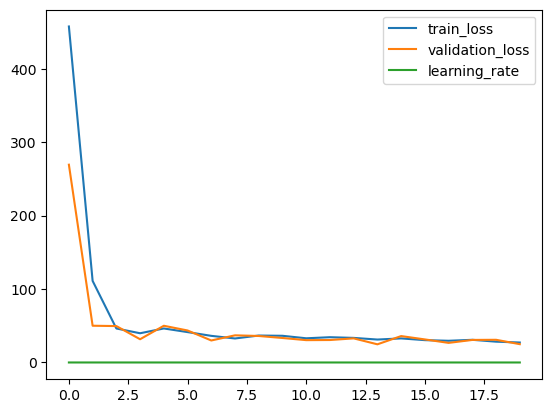

In [17]:
#example using cosmosis/qchem ANI1x dataset with filter and custom cosmosis model
model_params = {'in_channels': 63*63, #length of the longest molecule in the dataset
                'hidden': 2000, 
                'out_channels': 1, 
                'model_name': 'funnel'
               }

ds_params = {'train_params': {'input_dict': {'model_input': {'X': ['coulomb']},
                                             'criterion_input': {'target': ['wb97x_dz.energy']}},
                              'transforms': {'coulomb': [Pad((63,63)), Flatten()]},
                              'criterion': ['wb97x_dz.energy'],
                              'conformation': 'max',
                              'in_file': './data/ani1x/ani1x-release.h5'}}

metrics_params = {'report_interval': 20}

crit_params = {'reduction': 'sum'}
sample_params = {'set_seed': 88,
                 'splits': (.7,.15)}
sched_params = {'factor': .5,
                'patience': 2,
                'cooldown': 1}
opt_params = {'lr': 0.01}

l = Learn([ANI1x], FFNet, Selector, Optimizer=Adam, Scheduler=ReduceLROnPlateau, Criterion=L1Loss, 
          model_params=model_params, ds_params=ds_params, sample_params=sample_params,
          opt_params=opt_params, sched_params=sched_params, crit_params=crit_params,
          batch_size=64, epochs=20)